### Named Entity Recognition

This notebook imports the RSI's Confirmation Hearings dataset and searches for "named entities"--or what the algorithm considers to be a specific topic (person, place, organization, concept, etc) within the conversation. 

"Information extraction" of this variety is useful for quickly scanning large quantities of text data for key topics or issues, which can then be assessed more qualitatively by human eyes. In this case, we can look at each confirmation hearing individually, and quickly discern which issues and legal principles were most pressing at the time.

For example, this model lists the mutual fund company "Vanguard" as the most frequently cited organization in Justice Alito's confirmation hearing. This refers to conflict-of-interest allegations raised by Democratic Senators during the hearing, who suggested that Alito--an investor in Vanguard--might have been unduly influenced during a 2003 ruling involving the company.

We see that the Second Amendment was a key issue for both parties during Justice Sonia Sotomayor's hearing, as were the Equal Rights Amendment and Roe v. Wade during Justice Ruth Bader Ginsburg's. (Roe v. Wade is, unsurprisingly, among the top issues listed across this dataset).

While no information extraction model is perfect (if you explore this dataset, you'll notice plenty of head-scratching result) they can nevertheless give research efforts a huge head start, and be a helpful jumping off point for deeper analytics.

In [1]:
"""Start by defining nominee you'd like to analyze, and setting the 
number of entities you'd like to see for each category"""

nominee = 'gorsuch'
number_of_entities = 20 

#A maximum of 30 entities at a time is recommended, as otherwise the graphs become hard to read.

In [2]:
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import spacy
from spacy import displacy
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from hearing_junk_words import hearing_junk_words

nlp = spacy.load('en_core_web_sm')
lemmatizer = WordNetLemmatizer()
hearing_junk_words = [word.title() for word in hearing_junk_words]
stop_words = stopwords.words('english') + hearing_junk_words
tokenizer = RegexpTokenizer(r'\w+')

In [3]:
dataframe = pd.read_excel('confirmation_hearings.xlsx')
dataframe.columns = ['Total Order', 'Order', 'Year', 'Hearing', 'Title', 'Party', 'Speaker', 'Statements']

In [4]:
def remove_speaker_headers(text):
    try:
        text = text.split('.', 1)[1]
    except:
        pass
    return text

def join_text(statements):
    words = []
    for statement in statements:
        tokenized = word_tokenize(statement)
        for word in tokenized:
            words.append(word)
    full_text = ' '.join(words)
    return full_text

def remove_punctuation(text):
    punctuation_removed = tokenizer.tokenize(text)
    punctuation_removed = ' '.join(punctuation_removed)
    return punctuation_removed

def process_text(text):
    processed_words = []
    word_tokens = word_tokenize(remove_punctuation(text))
    for w in word_tokens:
        if w not in stop_words:
            word = lemmatizer.lemmatize(w)
            processed_words.append(word)
    processed = ' '.join(processed_words)
    return processed

#One of the quirks in this dataset is how frequently the different members of 
#Senate Committee refer to one another. This dramatically skews our results away from
#the actual substance of the discussions, so I have built a small function to remove
#these names from the analysis.
def add_speakers_as_stopwords(dataframe):
    speaker_stopwords = []
    for index, rows in dataframe.iterrows():
        speaker = rows['Speaker']
        
        cleaned = speaker.replace('Senator', '')
        cleaned = cleaned.split('(')[0]
        cleaned = cleaned.strip()
        cleaned = cleaned.split(' ')
        if len(cleaned) > 2:
            del cleaned[1]
        last_name = cleaned[1]
        if last_name not in speaker_stopwords:
            speaker_stopwords.append(last_name)
        first_name = cleaned[0]
        if first_name not in speaker_stopwords:
            speaker_stopwords.append(first_name)
        cleaned = ' '.join(cleaned)
        if cleaned not in speaker_stopwords:
            speaker_stopwords.append(cleaned)
    return speaker_stopwords

In [5]:
dataframe['Statements'] = list(map(remove_speaker_headers, dataframe['Statements']))

In [6]:
nominee = nominee.lower()
dataframe['Hearing'] = dataframe['Hearing'].str.lower()
hearing_df = dataframe[dataframe['Hearing'].str.contains(nominee)]
#Split the committee hearings by Party
df_gop = hearing_df.loc[hearing_df['Party'] == 'R']
df_dem = hearing_df.loc[hearing_df['Party'] == 'D']

#Combine both Party's statements into one large text block for Party level analysis
gop_statements = join_text(df_gop['Statements'].to_list())
dem_statements = join_text(df_dem['Statements'].to_list())

#Run the entity recognition process
gop_entities = nlp(gop_statements)
dem_entities = nlp(dem_statements)

In [7]:
#Lets first check out how the entity recognition module fared on the Republican dataset.
displacy.render(gop_entities, style='ent', jupyter=True)

In [8]:
#Now lets check on the Democrats.
displacy.render(dem_entities, style='ent', jupyter=True)

In [9]:
#Now lets clean and pre-process the data so we can deliver more informative analysis. This includes removing
#junk words ("stop words"), correcting for different versions of the same word, etc.

dem_stopwords = add_speakers_as_stopwords(df_dem)
gop_stopwords = add_speakers_as_stopwords(df_gop)
stop_words = stop_words + dem_stopwords + gop_stopwords 

processed_gop_statements = process_text(gop_statements)
processed_dem_statements = process_text(dem_statements)

processed_gop_entities = nlp(processed_gop_statements)
processed_dem_entities = nlp(processed_dem_statements)

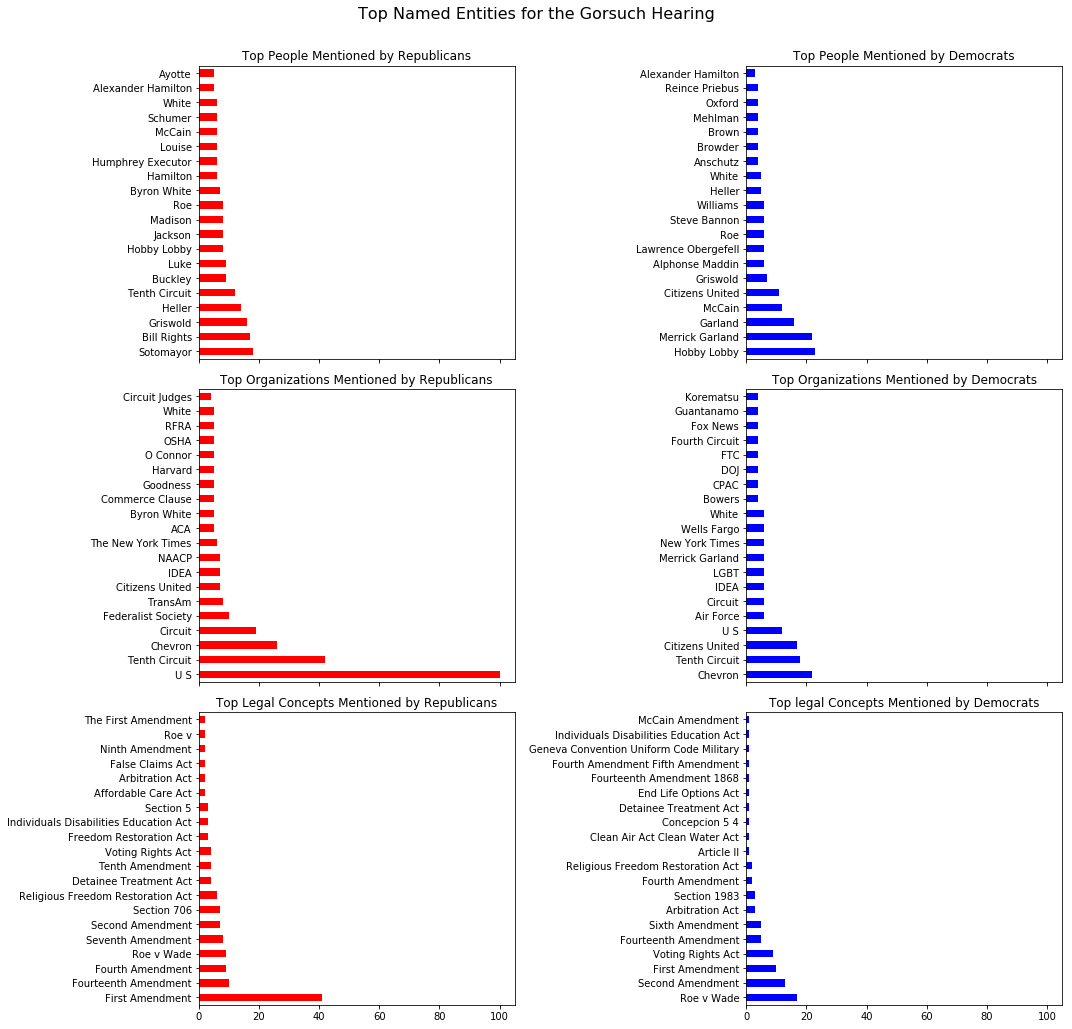

In [17]:
#Now for the fun part. We'll plot the most frequently occurring entities for both parties
#in the PERSON, ORGANIZATION, and LAW categories.

df_gop_entities = [(X.text, X.label_) for X in processed_gop_entities.ents]
df_gop_entities = pd.DataFrame(df_gop_entities, columns = ['entity', 'label'])
df_gop_entities['entity'] = df_gop_entities['entity'].str[:39]
gop_persons = df_gop_entities[df_gop_entities['label'] == 'PERSON']
grouped_gop_persons = gop_persons.groupby(['entity']).count().reset_index()
grouped_gop_persons = grouped_gop_persons.nlargest(number_of_entities, ['label']).set_index('entity')
gop_organizations = df_gop_entities[df_gop_entities['label'] == 'ORG']
grouped_gop_organizations = gop_organizations.groupby(['entity']).count().reset_index()
grouped_gop_organizations = grouped_gop_organizations.nlargest(number_of_entities, ['label']).set_index('entity')
gop_law = df_gop_entities[df_gop_entities['label'] == 'LAW']
grouped_gop_law = gop_law.groupby(['entity']).count().reset_index()
grouped_gop_law = grouped_gop_law.nlargest(number_of_entities, ['label']).set_index('entity')

df_dem_entities = [(X.text, X.label_) for X in processed_dem_entities.ents]
df_dem_entities = pd.DataFrame(df_dem_entities, columns = ['entity', 'label'])
df_dem_entities['entity'] = df_dem_entities['entity'].str[:39]
dem_persons = df_dem_entities[df_dem_entities['label'] == 'PERSON']
grouped_dem_persons = dem_persons.groupby(['entity']).count().reset_index()
grouped_dem_persons = grouped_dem_persons.nlargest(number_of_entities, ['label']).set_index('entity')
dem_organizations = df_dem_entities[df_dem_entities['label'] == 'ORG']
grouped_dem_organizations = dem_organizations.groupby(['entity']).count().reset_index()
grouped_dem_organizations = grouped_dem_organizations.nlargest(number_of_entities, ['label']).set_index('entity')
dem_law = df_dem_entities[df_dem_entities['label'] == 'LAW']
grouped_dem_law = dem_law.groupby(['entity']).count().reset_index()
grouped_dem_law = grouped_dem_law.nlargest(number_of_entities, ['label']).set_index('entity')

fig, axes = plt.subplots(nrows=3, ncols = 2, figsize=(15,15), sharex = True)
grouped_gop_persons.plot(ax=axes[0,0], kind='barh', legend = None, color='r')
grouped_gop_organizations.plot(ax=axes[1,0], kind='barh', legend=None, color='r')
grouped_gop_law.plot(ax=axes[2,0], kind='barh', legend=None, color='r')
grouped_dem_persons.plot(ax=axes[0,1], kind ='barh', legend=None, color='b')
grouped_dem_organizations.plot(ax=axes[1,1], kind ='barh', legend=None, color='b')
grouped_dem_law.plot(ax=axes[2,1], kind='barh', legend=None, color='b')

axes[0,0].set_title('Top People Mentioned by Republicans', fontsize = 12)
axes[0,0].set_ylabel('')
axes[1,0].set_title('Top Organizations Mentioned by Republicans')
axes[1,0].set_ylabel('')
axes[2,0].set_title('Top Legal Concepts Mentioned by Republicans')
axes[2,0].set_ylabel('')

axes[0,1].set_title('Top People Mentioned by Democrats')
axes[0,1].set_ylabel('')
axes[1,1].set_title('Top Organizations Mentioned by Democrats')
axes[1,1].set_ylabel('')
axes[2,1].set_title('Top legal Concepts Mentioned by Democrats')
axes[2,1].set_ylabel('')

fig.subplots_adjust(bottom=0.5)
fig.suptitle("Top Named Entities for the " + nominee.title() + " Hearing", fontsize=16)
fig.tight_layout(rect=[0,0.03, 1, 0.95])